In [1]:
from recognition import model_utils as mu
from recognition import train_model as tm
from recognition import evaluate_model as em
from recognition import csv_utils as cu
from recognition import image_utils as iu
from recognition import data_utils as du

%matplotlib inline

Using TensorFlow backend.


# 1 选择一些必要的参数

In [2]:
# global variables
BATCH_SIZE = 32 # batch size
IMAGE_SIZE = 224 # image size
COLOR_MODE = 'grayscale' # color mode 
RESCALE = 1./255

# 2 选择训练集和验证集路径

In [3]:
train_path, valid_path = 'datasets/train', 'datasets/validation' 

# 3 获取generator, 并进行数据增强

In [4]:
train_gen, train_generator = mu.my_generator(train_path, 
                                             rescale=RESCALE,
                                             horizontal_flip=False,
                                             vertical_flip=False,
                                             width_shift_range=0.1,
                                             height_shift_range=0.1,
                                             rotation_range=10,
                                             shear_range=10.0,
                                             zoom_range=0.1,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE, 
                                             color_mode=COLOR_MODE, 
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE))

valid_gen, valid_generator = mu.my_generator(valid_path, 
                                             rescale=RESCALE,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE, 
                                             color_mode=COLOR_MODE, 
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE))

print('Writing the class_indices into csv file.')
cu.write_list_or_dict_into_csv(train_generator.class_indices, csv_path='class_indices.csv')
print('OK!')

Found 35987 images belonging to 100 classes.
Found 4000 images belonging to 100 classes.
Writing the class_indices into csv file.
OK!


# 4 可视化数据增强的效果

In [5]:
image_path = 'visualize.jpg'

## 4.1 训练集数据增强

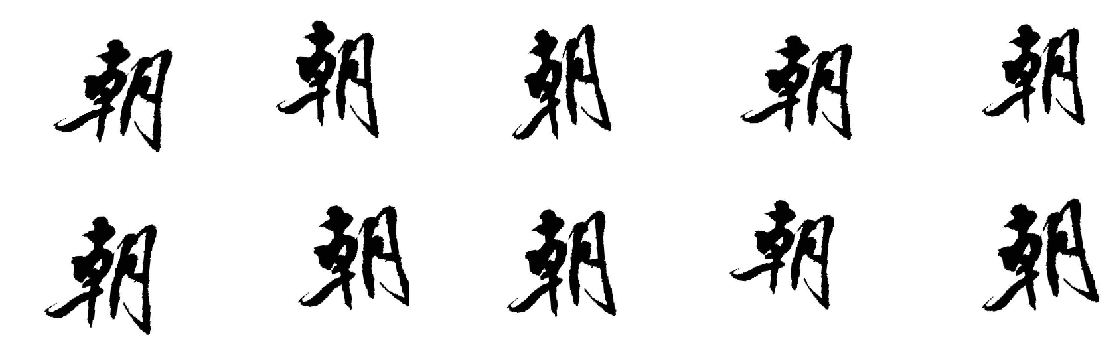

In [6]:
iu.show_image_by_keras_augmentation(train_gen, 
                                    image_path, 
                                    target_size=(224, 224), 
                                    visualizes_number=10)

## 4.2 验证集数据增强

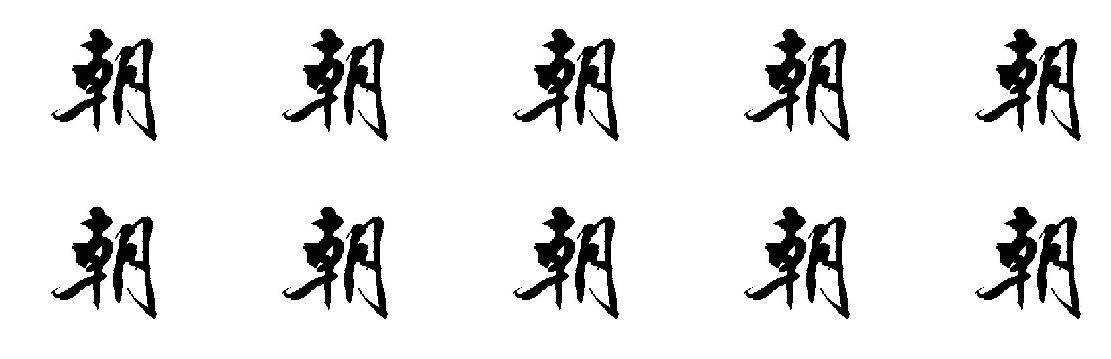

In [7]:
# 默认是没有增强的，所以效果是一样的
iu.show_image_by_keras_augmentation(valid_gen, 
                                    image_path, 
                                    target_size=(224, 224), 
                                    visualizes_number=10)

# 5 利用ResNet50训练

## 5.1 构建模型

In [8]:
from keras.applications.resnet50 import ResNet50
from keras.layers import BatchNormalization, Activation, Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, PReLU
from keras.models import Model
from keras.regularizers import l2


def build_model_based_on_resnet50(out_dims, 
                                  base_weights=None, 
                                  input_shape=(224, 224, 3), 
                                  weights=None):
    """ Build our model based on ResNet50.
    
    Inputs:
       - out_dims: An integer, number of classes.
       - base_weights: the weights of the original ResNet50.
       - input_shape: A tuple, shape of the input.
       - weights: The weights of model built based on ResNet50.
      
    Return:
       - model: The model built based on ResNet50.
    """
    resnet50_base_model = ResNet50(weights=base_weights, 
                                   include_top=False, 
                                   input_shape=input_shape)
    x = resnet50_base_model.output
    x = Flatten()(x)

    x = Dense(2048)(x)
    x = BatchNormalization()(x)
    x = PReLU()(x)
    x = Dropout(0.6)(x)
    
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = PReLU()(x)
    x = Dropout(0.6)(x)
    
    x = Dense(out_dims, kernel_regularizer=l2(0.01))(x)
    x = Activation('softmax')(x)
    model = Model(inputs=resnet50_base_model.input, outputs=x)
    
    if weights:
        model.load_weights(weights, by_name=True)

    return model

mu.clear_session()

channels = mu.get_channels(COLOR_MODE)
if channels is 1:
    base_weights = None
else:
    base_weights = 'imagenet'
    
model = build_model_based_on_resnet50(100, 
                                      base_weights=base_weights, 
                                      input_shape=(IMAGE_SIZE, IMAGE_SIZE, channels), 
                                      weights=None)

for index, layer in enumerate(model.layers):
    print(index, layer.name)
    
print('\n The architecture of the model:')
model.summary()

0 input_1
1 conv1_pad
2 conv1
3 bn_conv1
4 activation_1
5 max_pooling2d_1
6 res2a_branch2a
7 bn2a_branch2a
8 activation_2
9 res2a_branch2b
10 bn2a_branch2b
11 activation_3
12 res2a_branch2c
13 res2a_branch1
14 bn2a_branch2c
15 bn2a_branch1
16 add_1
17 activation_4
18 res2b_branch2a
19 bn2b_branch2a
20 activation_5
21 res2b_branch2b
22 bn2b_branch2b
23 activation_6
24 res2b_branch2c
25 bn2b_branch2c
26 add_2
27 activation_7
28 res2c_branch2a
29 bn2c_branch2a
30 activation_8
31 res2c_branch2b
32 bn2c_branch2b
33 activation_9
34 res2c_branch2c
35 bn2c_branch2c
36 add_3
37 activation_10
38 res3a_branch2a
39 bn3a_branch2a
40 activation_11
41 res3a_branch2b
42 bn3a_branch2b
43 activation_12
44 res3a_branch2c
45 res3a_branch1
46 bn3a_branch2c
47 bn3a_branch1
48 add_4
49 activation_13
50 res3b_branch2a
51 bn3b_branch2a
52 activation_14
53 res3b_branch2b
54 bn3b_branch2b
55 activation_15
56 res3b_branch2c
57 bn3b_branch2c
58 add_5
59 activation_16
60 res3c_branch2a
61 bn3c_branch2a
62 activatio

## 5.2 冻结网络

In [9]:
freeze_range = range(0, 0)
model = mu.freeze_layers(model, freeze_range)
mu.count_parameters(model) 

Total params: 28,890,980
Trainable params: 28,832,740
Non-trainable params: 58,240


## 5.3 训练网络

In [10]:
LEARNING_RATE = 0.001
DECAY = 0
EPOCHS = 10

model_path = 'models/ResNet50/model.h5'
history = tm.train_model(model,
                         train_generator, 
                         valid_generator,
                         model_path=model_path,
                         print_lr=False,
                         automatic_reduction=True,
                         patience=4,
                         reduce_factor=0.1,
                         reduce_time=6,
                         reduce_monitor='val_acc',
                         save_best='val_acc',
                         batch_size=BATCH_SIZE,
                         learning_rate=LEARNING_RATE,
                         decay=DECAY,
                         epochs=EPOCHS)

Epoch 1/10
1125/1125 [==============================] - 745s 662ms/step - loss: 5.0018 - acc: 0.0253 - val_loss: 5.0485 - val_acc: 0.0385
Epoch 2/10
1125/1125 [==============================] - 739s 657ms/step - loss: 3.4823 - acc: 0.1950 - val_loss: 3.6805 - val_acc: 0.1890
Epoch 3/10
1125/1125 [==============================] - 739s 657ms/step - loss: 2.5237 - acc: 0.4345 - val_loss: 2.4982 - val_acc: 0.4512
Epoch 4/10
1125/1125 [==============================] - 746s 663ms/step - loss: 1.8994 - acc: 0.6059 - val_loss: 1.7839 - val_acc: 0.6285
Epoch 5/10
1125/1125 [==============================] - 747s 664ms/step - loss: 1.5702 - acc: 0.6869 - val_loss: 1.2117 - val_acc: 0.7800
Epoch 6/10
1125/1125 [==============================] - 740s 658ms/step - loss: 1.3378 - acc: 0.7397 - val_loss: 1.3315 - val_acc: 0.7465
Epoch 7/10
1125/1125 [==============================] - 757s 673ms/step - loss: 1.1847 - acc: 0.7742 - val_loss: 1.0431 - val_acc: 0.8117
Epoch 8/10
1125/1125 [============

## 5.4 记录模型的信息，并写入csv文件

In [11]:
model_info = {}
model_info['batch_size'] = BATCH_SIZE
model_info['color_mode'] = COLOR_MODE
model_info['image_size'] = IMAGE_SIZE
model_info['rescale'] = RESCALE
model_info['algorithm'] = None
cu.write_list_or_dict_into_csv(model_info, csv_path='models/ResNet50/model.csv')
print('OK!')

OK!


## 5.5 绘制历史曲线

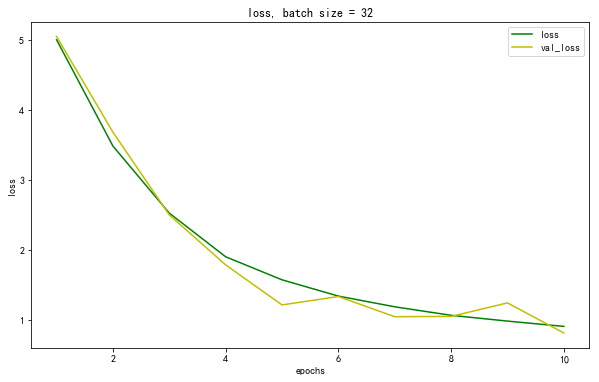

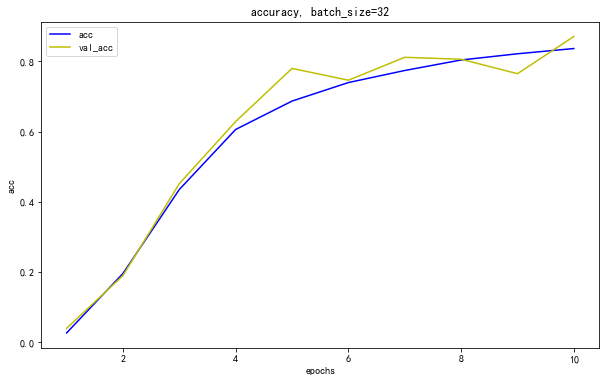

In [12]:
mu.draw_plot(history)

# 6 评估网络性能

## 6.1 载入模型以及模型的非权值参数

In [13]:
model, model_info = mu.load_my_model('models/ResNet50/model')

batch_size = int(model_info['batch_size'])
rescale = float(model_info['rescale'])
image_size = int(model_info['image_size'])
color_mode = model_info['color_mode']
algorithm = model_info['algorithm']

print('Model loaded successfully!')

Model loaded successfully!


## 6.2 获取class_indices

In [14]:
class_indices = cu.get_class_indices('class_indices.csv')
print(class_indices)

{'且': 0, '世': 1, '东': 2, '九': 3, '亭': 4, '今': 5, '从': 6, '令': 7, '作': 8, '使': 9, '侯': 10, '元': 11, '光': 12, '利': 13, '印': 14, '去': 15, '受': 16, '右': 17, '司': 18, '合': 19, '名': 20, '周': 21, '命': 22, '和': 23, '唯': 24, '堂': 25, '士': 26, '多': 27, '夜': 28, '奉': 29, '女': 30, '好': 31, '始': 32, '字': 33, '孝': 34, '守': 35, '宗': 36, '官': 37, '定': 38, '宜': 39, '室': 40, '家': 41, '寒': 42, '左': 43, '常': 44, '建': 45, '徐': 46, '御': 47, '必': 48, '思': 49, '意': 50, '我': 51, '敬': 52, '新': 53, '易': 54, '春': 55, '更': 56, '朝': 57, '李': 58, '来': 59, '林': 60, '正': 61, '武': 62, '氏': 63, '永': 64, '流': 65, '海': 66, '深': 67, '清': 68, '游': 69, '父': 70, '物': 71, '玉': 72, '用': 73, '申': 74, '白': 75, '皇': 76, '益': 77, '福': 78, '秋': 79, '立': 80, '章': 81, '老': 82, '臣': 83, '良': 84, '莫': 85, '虎': 86, '衣': 87, '西': 88, '起': 89, '足': 90, '身': 91, '通': 92, '遂': 93, '重': 94, '陵': 95, '雨': 96, '高': 97, '黄': 98, '鼎': 99}


## 6.3 评估网络模型准确度

### 6.3.1 选择评估数据集路径

In [15]:
evaluate_path = 'datasets/validation'

### 6.3.2 对数据集不使用数据增强

In [16]:
evaluate_gen, evaluate_generator = mu.my_generator(evaluate_path,
                                                   shuffle=False,
                                                   rescale=RESCALE, 
                                                   batch_size=BATCH_SIZE, 
                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                   color_mode=COLOR_MODE)

prediction = em.predict_without_augmentation(model, evaluate_generator)
output = {}
for k in [1, 5]:
    output[str(k)] = em.evaluate_topk_accuracy_by_single_generator(evaluate_generator, 
                                                                   class_indices,
                                                                   prediction=prediction, 
                                                                   k=k)

Found 4000 images belonging to 100 classes.
Top-1 accuracy: 87.12%
Top-5 accuracy: 96.10%


### 6.3.3 自己实现对数据集使用数据增强
- 对每张图像进行左上、左下、右上、右下、中心以及左旋10°右旋10°

In [17]:
evaluate_gen, evaluate_generator = mu.my_generator(evaluate_path,
                                                   shuffle=False,
                                                   rescale=RESCALE, 
                                                   batch_size=BATCH_SIZE, 
                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                   color_mode=COLOR_MODE)

Found 4000 images belonging to 100 classes.


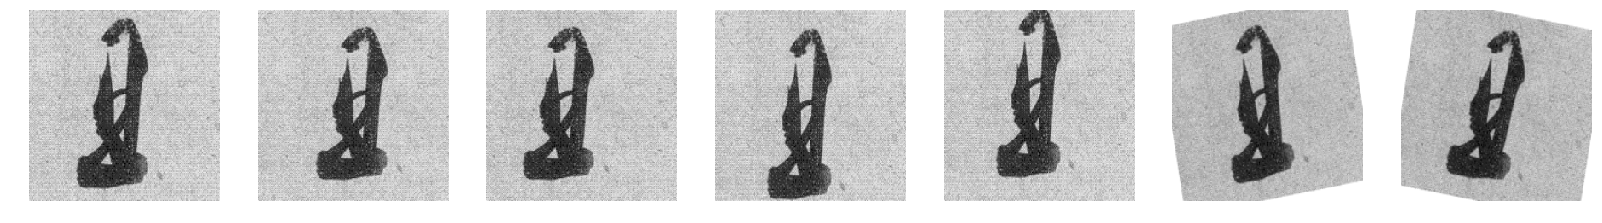

In [18]:
# 查看图像增强效果
prediction = em.predict_by_my_augmentation(model,
                                           evaluate_path,
                                           evaluate_generator, 
                                           batch_process=32, 
                                           num_classes=100,
                                           show_first_fig=True,
                                           rescale=RESCALE,
                                           color_mode=COLOR_MODE, 
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE))

In [19]:
prediction = em.predict_by_my_augmentation(model,
                                           evaluate_path,
                                           evaluate_generator, 
                                           batch_process=32, 
                                           num_classes=100,
                                           show_first_fig=False,
                                           rescale=RESCALE,
                                           color_mode=COLOR_MODE, 
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE))
output = {}
for k in [1, 5]:
    output[str(k)] = em.evaluate_topk_accuracy_by_single_generator(evaluate_generator, 
                                                                   class_indices,
                                                                   prediction=prediction, 
                                                                   k=k)

Top-1 accuracy: 87.05%
Top-5 accuracy: 96.35%


### 6.3.4 通过Keras API对验证集使用数据增强
- 对每张图像选择若干张增强后的图像进行预测

In [20]:
horizontal_flip = False
vertical_flip = False
width_shift_range = 0.1
height_shift_range = 0.1
rotation_range = 10
shear_range = 10.0
zoom_range = 0.1
channel_shift_range = 0.0
shuffle = False
augment_size = 6
                                
evaluate_gen, evaluate_generator = mu.my_generator(evaluate_path, 
                                                   rescale=rescale,
                                                   horizontal_flip=horizontal_flip,
                                                   vertical_flip=vertical_flip,
                                                   width_shift_range=width_shift_range,
                                                   height_shift_range=height_shift_range,
                                                   rotation_range=rotation_range,
                                                   shear_range=shear_range,
                                                   zoom_range=zoom_range,
                                                   channel_shift_range=channel_shift_range,
                                                   shuffle=shuffle,
                                                   batch_size=batch_size, 
                                                   color_mode=color_mode, 
                                                   target_size=(image_size, image_size))


Found 4000 images belonging to 100 classes.


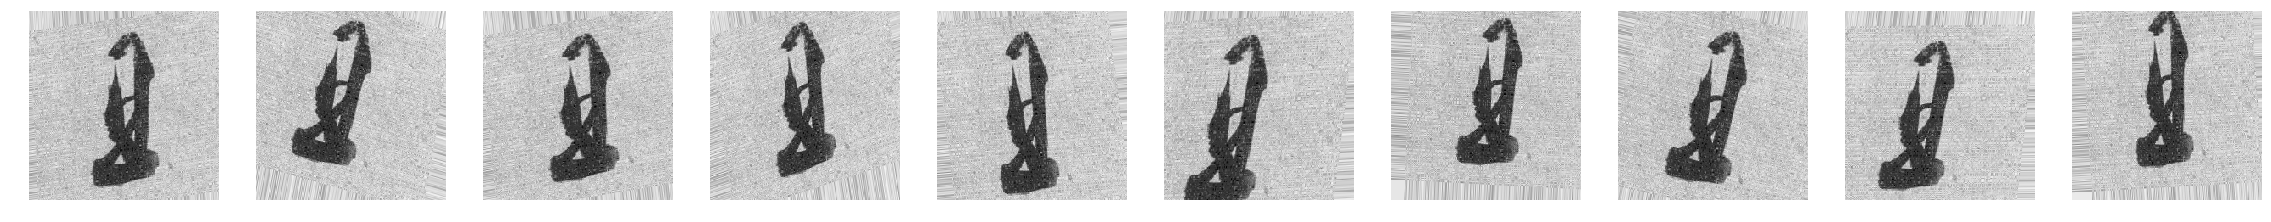

In [21]:
prediction = em.predict_by_keras_augmentation(model,
                                              evaluate_path,
                                              evaluate_gen,
                                              evaluate_generator, 
                                              batch_process=32, 
                                              augment_size=10,
                                              num_classes=100,
                                              show_first_fig=True,
                                              color_mode=COLOR_MODE, 
                                              target_size=(IMAGE_SIZE, IMAGE_SIZE))

In [22]:
prediction = em.predict_by_keras_augmentation(model,
                                              evaluate_path,
                                              evaluate_gen,
                                              evaluate_generator, 
                                              batch_process=32, 
                                              augment_size=augment_size,
                                              num_classes=100,
                                              show_first_fig=False,
                                              color_mode=COLOR_MODE, 
                                              target_size=(IMAGE_SIZE, IMAGE_SIZE))
output = {}
for k in [1, 5]:
    output[str(k)] = em.evaluate_topk_accuracy_by_single_generator(evaluate_generator, 
                                                                   class_indices,
                                                                   prediction=prediction, 
                                                                   k=k)

Top-1 accuracy: 86.62%
Top-5 accuracy: 96.23%


## 6.4 查看错误信息

In [23]:
correct_number, total_number, topk_indices, topk_classes, wrong_info = output[str(5)]
for info in wrong_info:
    print(info)

{'filename': '9d73098ba76ef909cc64ac99161735b9e6d4d68d.jpg', 'correct': '且', 'predict': ['易', '流', '陵', '我', '敬']}
{'filename': '28c051c6c80c5f52136b3f5330f3e93d104a99b6.jpg', 'correct': '世', 'predict': ['益', '秋', '利', '孝', '林']}
{'filename': '2bc30abd59d981591a8e21bc61594eaaf15da2a1.jpg', 'correct': '世', 'predict': ['好', '海', '深', '父', '受']}
{'filename': '5576738f26bf69ed7dc44c1a6390e0fe9a7b14db.jpg', 'correct': '世', 'predict': ['利', '好', '孝', '鼎', '易']}
{'filename': '732a8affdc3afae45821107d658a5e35a37fbc20.jpg', 'correct': '世', 'predict': ['右', '女', '名', '去', '多']}
{'filename': '874145c419a375b84b0273c68d5ec747cb454d76.jpg', 'correct': '东', 'predict': ['去', '父', '身', '建', '足']}
{'filename': '4b7a9b8bb21b72936c1257b6b95b58051ddfd714.jpg', 'correct': '九', 'predict': ['今', '氏', '世', '父', '女']}
{'filename': '60a94c9fed36d5c1f765fba26b7abefc5ce6c39d.jpg', 'correct': '九', 'predict': ['女', '士', '足', '正', '父']}
{'filename': '69721d87a5d4705a6408d4da29a970d774437e7f.jpg', 'correct': '九', 'pr

## 6.5 可视化错误图像

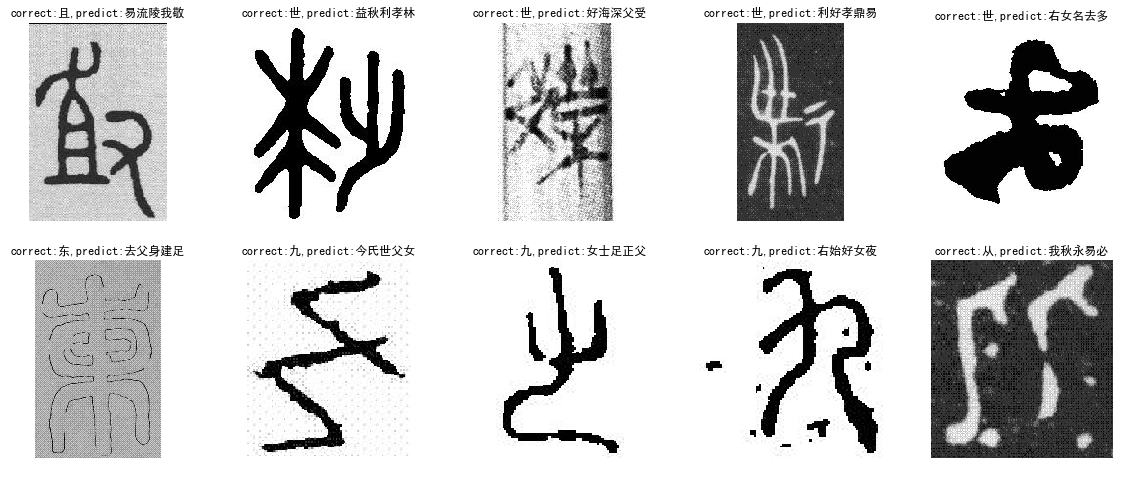

In [24]:
iu.show_images_in_wrong_info(wrong_info, evaluate_path, visualizes_number=10)

## 6.6 选择最优的预测算法
- `no_aug`: 不使用数据增强
- `my_aug`: 使用自己的数据增强方法
- `ke_aug`: 使用Keras API的数据增强方法

In [25]:
algorithm = 'ke_aug'
model_info['algorithm'] = algorithm
if algorithm == 'ke_aug':
    model_info['horizontal_flip'] = horizontal_flip
    model_info['vertical_flip'] = vertical_flip
    model_info['width_shift_range'] = width_shift_range
    model_info['height_shift_range'] = height_shift_range
    model_info['rotation_range'] = rotation_range
    model_info['shear_range'] = shear_range
    model_info['zoom_range'] = zoom_range
    model_info['channel_shift_range'] = channel_shift_range
    model_info['shuffle'] = shuffle
    model_info['augment_size'] = augment_size
    
cu.write_list_or_dict_into_csv(model_info, csv_path='models/ResNet50/model.csv')

# 7 预测测试集

## 7.1 载入模型和非权值参数

In [26]:
model, model_info = mu.load_my_model('models/ResNet50/model')

batch_size = int(model_info['batch_size'])
rescale = float(model_info['rescale'])
image_size = int(model_info['image_size'])
color_mode = model_info['color_mode']
algorithm = model_info['algorithm']

if algorithm == 'ke_aug':
    horizontal_flip = model_info['horizontal_flip']=='True'
    vertical_flip = model_info['vertical_flip']=='True'
    width_shift_range = float(model_info['width_shift_range'])
    height_shift_range = float(model_info['height_shift_range'])
    rotation_range = int(model_info['rotation_range'])
    shear_range = float(model_info['shear_range'])
    zoom_range = float(model_info['zoom_range'])
    channel_shift_range = float(model_info['channel_shift_range'])
    shuffle = model_info['shuffle']=='True'
    augment_size = int(model_info['augment_size'])
    

print('Model loaded successfully!')

Model loaded successfully!


## 7.2 选择k值、测试集的路径以及预测算法

In [27]:
k = 5
test_path = 'datasets/validation'

algorithm = 'my_aug'
if algorithm not in ['no_aug', 'my_aug', 'ke_aug']:
    raise ValueError('The algorithm must be \'no_aug\', \'my_aug\' or \'ke_aug\'.')

## 7.3 获取top-k预测值

In [28]:
if algorithm == 'no_aug' or algorithm == 'my_aug':
    test_gen, test_generator = mu.my_generator(test_path,
                                               shuffle=False,
                                               rescale=rescale, 
                                               batch_size=batch_size, 
                                               target_size=(image_size, image_size), 
                                               color_mode=color_mode)
elif algorithm == 'ke_aug':
    test_gen, test_generator = mu.my_generator(test_path, 
                                               rescale=rescale,
                                               horizontal_flip=horizontal_flip,
                                               vertical_flip=vertical_flip,
                                               width_shift_range=width_shift_range,
                                               height_shift_range=height_shift_range,
                                               rotation_range=rotation_range,
                                               shear_range=shear_range,
                                               zoom_range=zoom_range,
                                               channel_shift_range=channel_shift_range,
                                               shuffle=shuffle,
                                               batch_size=batch_size, 
                                               color_mode=color_mode, 
                                               target_size=(image_size, image_size))
    
prediction = em.get_prediction_by_pre_trained_model(model, 
                                                    test_generator, 
                                                    dataset_path=test_path,
                                                    gen=test_gen, 
                                                    batch_process=32,
                                                    num_classes=100,
                                                    show_first_fig=False,
                                                    color_mode=color_mode, 
                                                    rescale=rescale, 
                                                    augment_size=augment_size,
                                                    target_size=(image_size, image_size), 
                                                    algorithm=algorithm)
print('OK!')

Found 4000 images belonging to 100 classes.
OK!


## 7.4 获取top-k的结果并写入文件

In [29]:
topk_indices = em.get_topk_indices_by_single_generator(test_generator, 
                                                       prediction=prediction, 
                                                       k=k)
results = cu.get_topk_pd_data(test_generator, 
                         class_indices, 
                         topk_indices=topk_indices)
cu.write_pd_data_into_csv(results, 
                          'results/ResNet50/top{}_results_ResNet50.csv'.format(k), 
                          have_chinese=True, 
                          index=None, 
                          header=True)
print('OK!')

OK!


## 7.5 获取top-1的结果并写入文件

In [30]:
top1_results = cu.get_top1_pd_data_from_topk('results/ResNet50/top{}_results_ResNet50.csv'.format(k), 
                                             'results/ResNet50/top1_results_ResNet50.csv')
cu.write_pd_data_into_csv(top1_results, 
                          'results/ResNet50/top1_results_ResNet50.csv', 
                          have_chinese=True, 
                          index=None, 
                          header=True)
print('OK!')

OK!
